In [6]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
df = pd.read_csv('/kaggle/input/dataset4-0/datasets2.csv')

In [ ]:
#Feature Engineering
features_list = [
    'Rainfall_mm',
    'Slope_Angle',
    'Soil_Saturation',
    'Vegetation_Cover',
    'Earthquake_Activity',
    'Proximity_to_Water',
    'Soil_Type_Gravel',
    'Soil_Type_Sand',
    'Soil_Type_Silt'
]

# Convert to numeric
for col in features_list:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Landslide'] = pd.to_numeric(df['Landslide'], errors='coerce')

df_clean = df.dropna(subset=features_list + ['Landslide']).copy()

X = df_clean[features_list]
y = df_clean['Landslide']

df_clean.loc[:, 'Soil_Risk_Index'] = (
    0.2 * df_clean['Soil_Type_Gravel'] +
    0.6 * df_clean['Soil_Type_Sand'] +
    1.0 * df_clean['Soil_Type_Silt']
)

df_clean.loc[:, 'Rain_Sand'] = (
    df_clean['Rainfall_mm'] * df_clean['Soil_Type_Sand']
)

df_clean.loc[:, 'Slope_Silt'] = (
    df_clean['Slope_Angle'] * df_clean['Soil_Type_Silt']
)


final_features = features_list + [
    'Soil_Risk_Index',
    'Rain_Sand',
    'Slope_Silt'
]

X = df_clean[final_features]


In [ ]:
#Training & Testing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
#Model Training on Random Forest
model = RandomForestClassifier(
    n_estimators=300,
    max_features=3,          
    min_samples_leaf=5,
    class_weight={0: 1, 1: 2},
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_features=3,
                       min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
#Model Evaluation
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred) * 100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 94.72049689440993

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       185
           1       0.89      1.00      0.94       137

    accuracy                           0.95       322
   macro avg       0.94      0.95      0.95       322
weighted avg       0.95      0.95      0.95       322


Confusion Matrix:
 [[168  17]
 [  0 137]]


In [ ]:
#MODEL SUMMARY
def random_forest_summary(model, X_train, y_train):
    print("\n" + "="*55)
    print("           RANDOM FOREST MODEL SUMMARY")
    print("="*55)
    print(f"Number of Trees       : {len(model.estimators_)}")
    print(f"Number of Features    : {X_train.shape[1]}")
    print(f"Training Samples      : {X_train.shape[0]}")
    print(f"Target Classes        : {np.unique(y_train)}")

    depths = [tree.tree_.max_depth for tree in model.estimators_]
    print(f"Average Tree Depth    : {np.mean(depths):.2f}")
    print(f"Maximum Tree Depth    : {np.max(depths)}")

    print("\nFeature Importances:")
    for name, imp in zip(X_train.columns, model.feature_importances_):
        print(f"{name:25s}: {imp:.4f}")

    print("="*55)

random_forest_summary(model, X_train, y_train)


           RANDOM FOREST MODEL SUMMARY
Number of Trees       : 300
Number of Features    : 12
Training Samples      : 1284
Target Classes        : [0 1]
Average Tree Depth    : 9.35
Maximum Tree Depth    : 15

Feature Importances:
Rainfall_mm              : 0.0838
Slope_Angle              : 0.0578
Soil_Saturation          : 0.2673
Vegetation_Cover         : 0.1897
Earthquake_Activity      : 0.1785
Proximity_to_Water       : 0.1717
Soil_Type_Gravel         : 0.0245
Soil_Type_Sand           : 0.0136
Soil_Type_Silt           : 0.0009
Soil_Risk_Index          : 0.0005
Rain_Sand                : 0.0069
Slope_Silt               : 0.0047


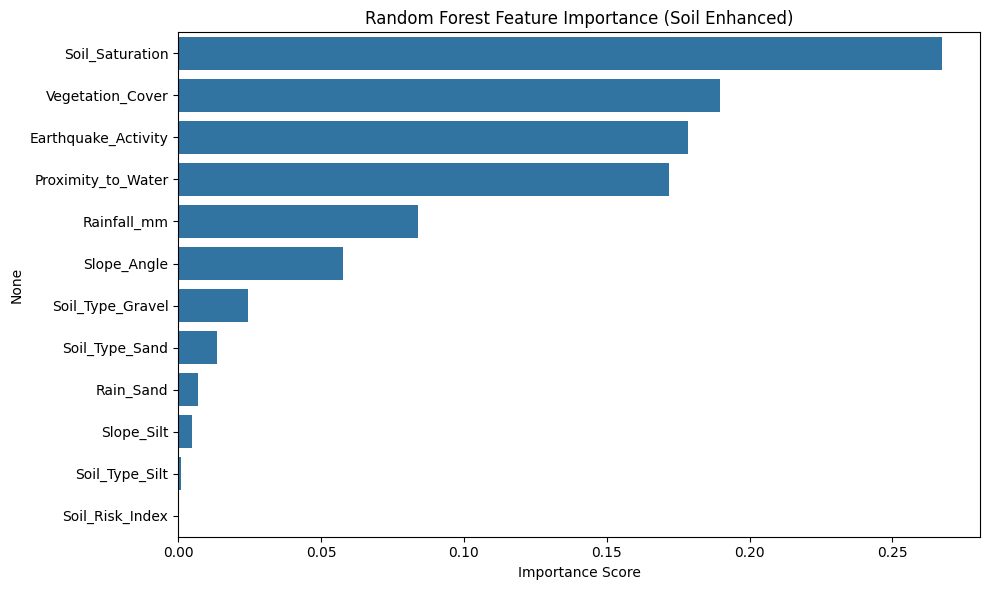

In [ ]:
#Feature Importance plot
plt.figure(figsize=(10, 6))
importances = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest Feature Importance (Soil Enhanced)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
#Permutation Importance
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model,
    X_test,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

print(perm_importance)


Earthquake_Activity    0.031848
Soil_Saturation        0.017558
Vegetation_Cover       0.011837
Proximity_to_Water     0.011288
Rainfall_mm            0.003480
Soil_Type_Gravel       0.001046
Slope_Angle            0.000375
Soil_Type_Sand         0.000268
Rain_Sand              0.000095
Soil_Type_Silt        -0.000213
Soil_Risk_Index       -0.000422
Slope_Silt            -0.000517
dtype: float64


In [ ]:
#Sample Data Prediction
import pandas as pd
new_sample = pd.DataFrame({
    'Rainfall_mm': [35.0],            
    'Slope_Angle': [6.0],              
    'Soil_Saturation': [0.18],         
    'Vegetation_Cover': [0.92],        
    'Earthquake_Activity': [0.0],      
    'Proximity_to_Water': [3.8],       

    # Soil type: GRAVEL (most stable)
    'Soil_Type_Gravel': [1],
    'Soil_Type_Sand': [0],
    'Soil_Type_Silt': [0],

    'Soil_Risk_Index': [0.12],         

    # Interaction features
    'Rain_Sand': [0.0],                
    'Slope_Silt': [0.0]
})

prob = model.predict_proba(new_sample)[0][1]

print("\n Prediction Result")
print("Risk Level:", "LANDSLIDE" if prob > 0.5 else "SAFE")
print(f"Risk Probability: {prob:.2%}")



 Prediction Result
Risk Level: SAFE
Risk Probability: 0.00%


In [ ]:
#MODEL LOAD
import pickle

with open("landslide_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as landslide_model.pkl")


Model saved as landslide_model.pkl


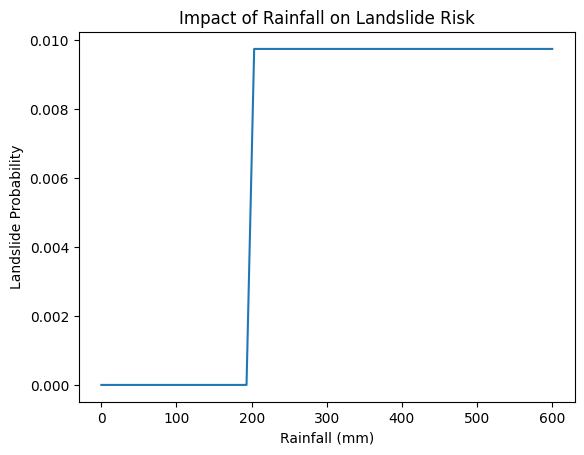

In [ ]:
#Rainfall Impact 
import numpy as np

rainfall_range = np.linspace(0, 600, 60)
temp = new_sample.copy()

probs = []
for r in rainfall_range:
    temp['Rainfall_mm'] = r
    probs.append(model.predict_proba(temp)[0][1])

plt.figure()
plt.plot(rainfall_range, probs)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Landslide Probability")
plt.title("Impact of Rainfall on Landslide Risk")
plt.show()


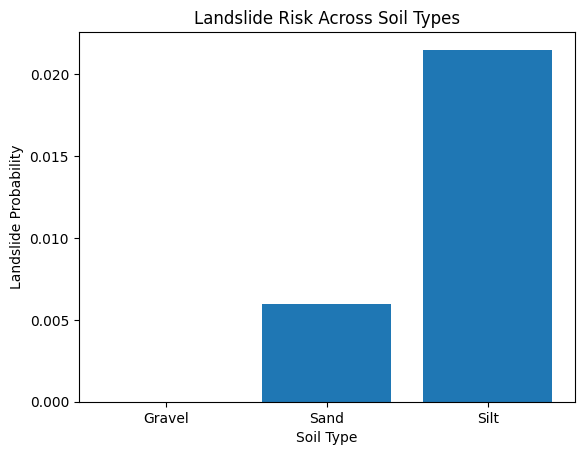

In [ ]:
#Landslide risk across soil type graph
soil_types = ["Gravel", "Sand", "Silt"]
probs = []

for soil in soil_types:
    temp = new_sample.copy()
    temp[['Soil_Type_Gravel','Soil_Type_Sand','Soil_Type_Silt']] = [0,0,0]
    
    if soil == "Gravel":
        temp['Soil_Type_Gravel'] = 1
        temp['Slope_Silt'] = 0
    elif soil == "Sand":
        temp['Soil_Type_Sand'] = 1
        temp['Slope_Silt'] = 0
    else:
        temp['Soil_Type_Silt'] = 1
        temp['Slope_Silt'] = temp['Slope_Angle']
    
    probs.append(model.predict_proba(temp)[0][1])

plt.figure()
plt.bar(soil_types, probs)
plt.xlabel("Soil Type")
plt.ylabel("Landslide Probability")
plt.title("Landslide Risk Across Soil Types")
plt.show()


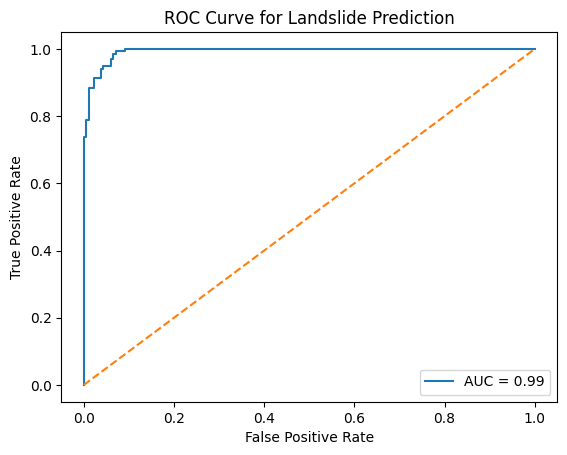

In [ ]:
#ROC Curve for landslide prediction
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Probabilities of class 1 (LANDSLIDE)
y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Landslide Prediction")
plt.legend()
plt.show()


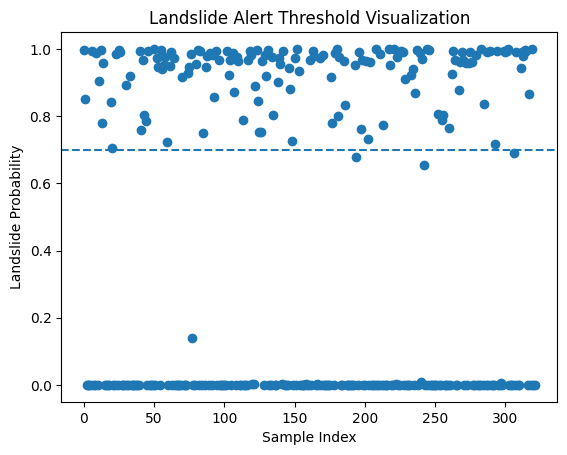

In [ ]:
#Threshold Visualization
threshold = 0.7

plt.figure()
plt.scatter(range(len(y_proba)), y_proba)
plt.axhline(y=threshold, linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Landslide Probability")
plt.title("Landslide Alert Threshold Visualization")
plt.show()



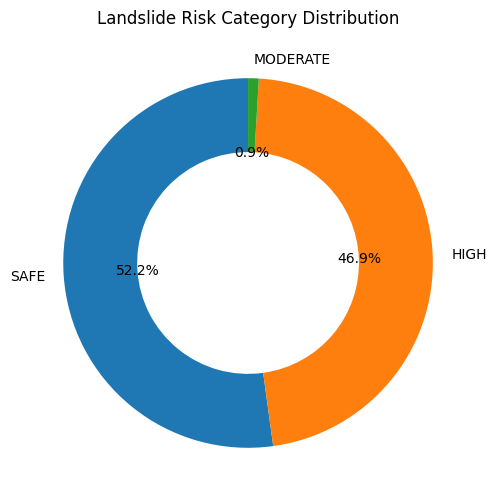

In [ ]:
#Landslide risk distribution
import numpy as np

risk_labels = []
for p in y_proba:
    if p < 0.4:
        risk_labels.append("SAFE")
    elif p < 0.7:
        risk_labels.append("MODERATE")
    else:
        risk_labels.append("HIGH")

risk_counts = pd.Series(risk_labels).value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    risk_counts.values,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.4}
)
plt.title("Landslide Risk Category Distribution")
plt.show()
